In [1]:
# !python -Xfrozen_modules=off -m ipykernel kernel install --user --name python3
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


# EDA

Six preactices

1. Discovering
2. Structuring
3. Cleaning
4. Joining
5. Validating
6. Presenting

## 1. Discovering

We will start from Discovering to get familiar with the data
following may be helpful functions in discovering

- head()
- sample()
- size()
- shape() 

In [5]:
print(df.shape)
print(df.size)
print(df.info())

(11504798, 12)
138057576
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB
None


In [6]:
df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000
mean,5752398.500,38.384,0.998,26.419,0.463,30461.370,112.425,163.898,0.123
std,3321149.255,14.993,0.044,12.992,0.499,16454.745,54.036,79.980,0.328
min,0.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,2876199.250,24.000,1.000,15.000,0.000,25277.000,29.000,99.000,0.000
50%,5752398.500,36.000,1.000,28.000,0.000,31824.000,151.000,166.000,0.000
75%,8628597.750,49.000,1.000,35.000,1.000,39451.000,152.000,232.000,0.000
max,11504797.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


In [7]:
features_categorical = ['Gender', 'Driving_License', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
features_numerical = ['Age', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

### 1st iter of Discovering phase is completed

## 2. Structuring
structure for categorical and nuermical data

### Drop irrelevent columns i.e., ID

In [8]:
df = df.drop(columns='id')

In [9]:
print('Unique categories for categorical features\n')
for col in df[features_categorical]:
    print("{}: {} unique categories \n{}".format(col , len(df[col].unique()), df[col].unique()))
    print()

Unique categories for categorical features

Gender: 2 unique categories 
['Male' 'Female']

Driving_License: 2 unique categories 
[1 0]

Region_Code: 54 unique categories 
[35.  28.  14.   1.  15.  47.  45.   8.  11.   3.  10.  12.  37.  50.
 30.  46.  29.  16.  26.  25.  41.  48.   7.   4.  24.  36.  33.   2.
  9.  27.  18.  43.  49.  17.  13.  38.   6.  21.  23.   0.  19.   5.
 39.  44.  20.  40.  22.  32.  42.  31.  34.  51.  52.  39.2]

Vehicle_Age: 3 unique categories 
['1-2 Year' '> 2 Years' '< 1 Year']

Vehicle_Damage: 2 unique categories 
['Yes' 'No']



We have done to figure out the categorical features by seeking the number of categroies each
feature contains. 

It is found that except Region_Code, every categoircal features has two categories
It is also seem that the category in Region_Code 39.2 is a mistake or outlier, lets check the frequency of 39.2 

In [10]:
code_392 = df.Region_Code.value_counts()
code_392[39.2]

1

It is better for categorical features to be transferred to "category" data-type for all features
that are float or other type

In [11]:
df[features_categorical] = df[features_categorical].astype('category')
df.info()
# df['Vehicle_Age'].dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                category
 1   Age                   int64   
 2   Driving_License       category
 3   Region_Code           category
 4   Previously_Insured    int64   
 5   Vehicle_Age           category
 6   Vehicle_Damage        category
 7   Annual_Premium        float64 
 8   Policy_Sales_Channel  float64 
 9   Vintage               int64   
 10  Response              int64   
dtypes: category(5), float64(2), int64(4)
memory usage: 581.5 MB


In [12]:
df['Region_Code'] = df['Region_Code'].astype(str).str[:-2]
df['Region_Code'].value_counts()

Region_Code
28    3451062
8     1021036
46     578208
41     557581
15     403977
30     367307
29     338146
50     302334
11     278261
36     261946
3      246303
33     232387
47     229190
35     200035
6      181122
45     159292
37     158976
18     148548
39     138069
14     134585
21     126793
10     126081
2      118097
48     114230
13     108838
9       93371
7       92240
12      92142
27      78878
32      78797
43      75868
17      74533
26      71228
25      70556
24      69136
38      60587
0       59274
20      58765
31      58442
16      54905
23      54518
4       52504
49      50822
34      48685
19      44197
22      36932
5       36832
40      35888
1       33966
44      20305
42      13693
52       3450
51       1880
Name: count, dtype: int64

ah! we were right about the 39.2, its a mistakenly enetered region code. All other categoies have thousands of values.
lets fix it in Region_Code 39.0

### Now we have 53 categories in Region_Code

Moving further, Now part of the structuring phase we make some transformations in data.
### 1. Transform to check frequencies of categorical features

In [13]:
for col in features_categorical:
    print(df[col].value_counts())

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64
Driving_License
1    11482041
0       22757
Name: count, dtype: int64
Region_Code
28    3451062
8     1021036
46     578208
41     557581
15     403977
30     367307
29     338146
50     302334
11     278261
36     261946
3      246303
33     232387
47     229190
35     200035
6      181122
45     159292
37     158976
18     148548
39     138069
14     134585
21     126793
10     126081
2      118097
48     114230
13     108838
9       93371
7       92240
12      92142
27      78878
32      78797
43      75868
17      74533
26      71228
25      70556
24      69136
38      60587
0       59274
20      58765
31      58442
16      54905
23      54518
4       52504
49      50822
34      48685
19      44197
22      36932
5       36832
40      35888
1       33966
44      20305
42      13693
52       3450
51       1880
Name: count, dtype: int64
Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: 

From the above analysis, Driving_Lisence, Region_Code, Vehicle_Age and
targeted variable Response are imbalanced categoies

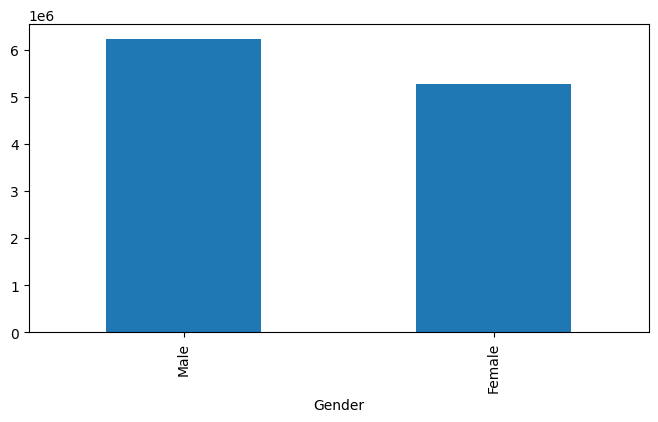

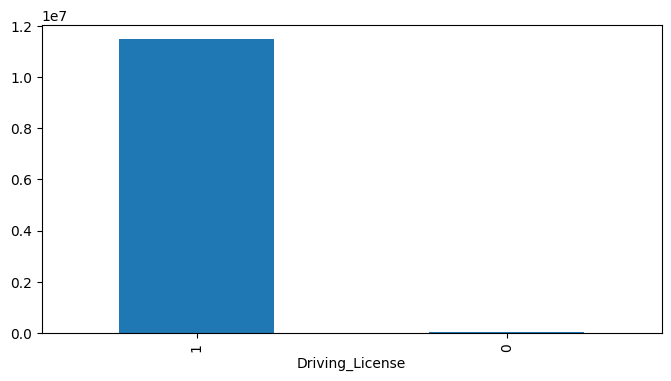

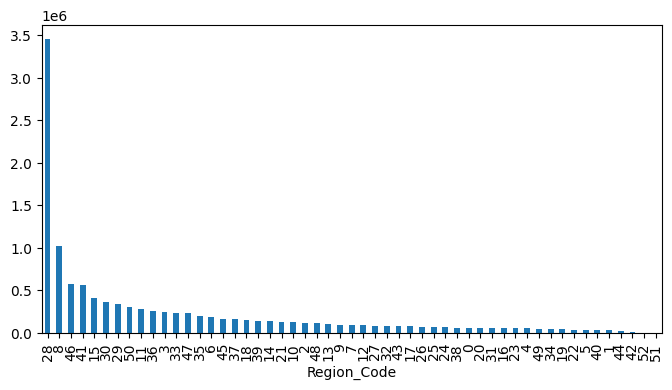

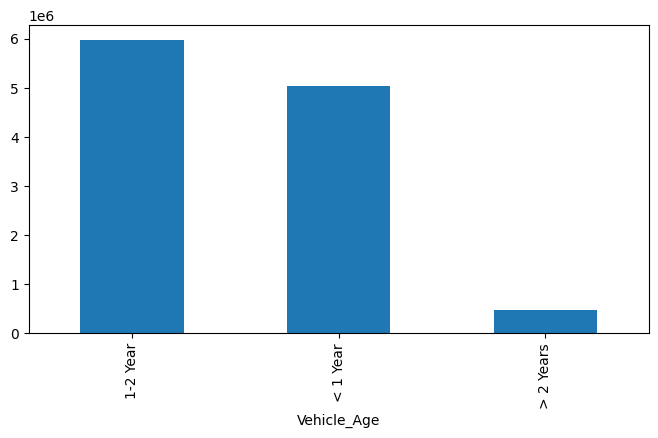

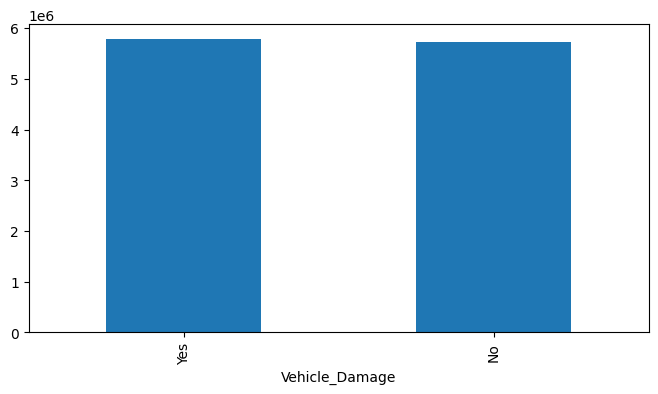

'\nThe best option for categorical features, categories count is to use df.plot(kind=barplot). with the other\nbenifits, it aranges data for developer\n'

In [14]:
for col in features_categorical:
    df_barplot = df[col].value_counts()
    df_barplot.plot(kind='bar', figsize=(8,4))
    # plt.bar(x=df[col].value_counts().index, height=df[col].value_counts().values)`
    plt.show()
"""
The best option for categorical features, categories count is to use df.plot(kind=barplot). with the other
benifits, it aranges data for developer
"""

In [15]:
### Convert dategorical features to one hot enUnicodeWarning
df_target = df['Response']
df_features = pd.get_dummies(df.drop(columns = 'Response'), drop_first=True)

In [16]:
X = df_features.copy()
y = df_target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

print(df_features.shape)
print(X_train.shape)

(11504798, 62)
(8628598, 62)


In [18]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [19]:
y_predict = gnb.predict_proba(X_val)
y_predict_idxs = np.argmax(y_predict, axis=1)

In [20]:
print(recall_score(y_val, y_predict_idxs))
print(precision_score(y_val, y_predict_idxs))
print(accuracy_score(y_val, y_predict_idxs))
print(roc_auc_score(y_val, y_predict_idxs))

0.7969556061227085
0.2789913621380811
0.7217001599332452
0.7540506919564101


In [21]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [22]:
df_test = df_test.drop(columns='id')
df_test[features_categorical] = df_test[features_categorical].astype('category')
df_test['Region_Code'] = df_test['Region_Code'].astype(str).str[:-2]
df_test = pd.get_dummies(df_test, drop_first=True)

In [23]:
X_test = df_test.copy()
X_test = scaler.transform(X_test)
y_pred = gnb.predict_proba(X_test)

In [24]:
df_submission['Response'] = y_pred[:,1]
df_submission.head()
df_submission.to_csv('submission_naive_bayes_2.csv', index=False)